In [1]:
# import the necessary modules
import pandas as pd
import numpy as np
import os
#waveform-database:A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb 

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt

mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

MAIN_PATH = "/kaggle/"
DATA_PATH = "/kaggle/input/cardiocare/mit-bih-arrhythmia-database-1.0.0"
FIG_PATH="/kaggle/working/Saving figure"
FIGURE_PATH = os.path.join(FIG_PATH,"saved_figures")
# os.makedirs("saved_figures",exist_ok=True)
os.chdir(DATA_PATH)

#a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIGURE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
records = np.loadtxt(os.path.join(DATA_PATH,"RECORDS"), dtype=str)
print(records)
print(len(records))

['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '121' '122' '123' '124' '200'
 '201' '202' '203' '205' '207' '208' '209' '210' '212' '213' '214' '215'
 '217' '219' '220' '221' '222' '223' '228' '230' '231' '232' '233' '234']
48


In [3]:
def read_data():
    dataset = []
    for record in records:
        temp = wfdb.rdrecord(record)
        dataset.append(temp.p_signal)
    return dataset
dataset = read_data()

In [4]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=",'"', "@", "B", "a", "J", "S",
    "r", "F", "e", "j", "n", "f", "Q", "?"
]

label_beats=[
    "A", "L", "/", "V", "R", "E", "N"
]

# Loading signals and segmentation

In [5]:
import wfdb
import pywt
import numpy as np
from scipy.ndimage import median_filter
from scipy.signal import savgol_filter

def classify(symbol):
    if symbol in label_beats:
        return 1
    else:
        return 0

def segment(signal_MLII, beat_loc):
    window = 180
    x = beat_loc - window
    y = beat_loc + window
    samp = signal_MLII[x:y]
    return samp

def perform_swt(signal, wavelet='db1', level=3):
    # Perform SWT decomposition
    coeffs = pywt.swt(signal, wavelet=wavelet, level=level)
    return coeffs

def two_stage_median_filter(signal, size=3):
    # First stage: apply median filter
    first_stage = median_filter(signal, size=size)
    
    # Second stage: apply median filter again
    second_stage = median_filter(first_stage, size=size)
    
    return second_stage

def apply_savitzky_golay(signal, window_length=5, polyorder=2):
    # Apply Savitzky-Golay filter
    return savgol_filter(signal, window_length=window_length, polyorder=polyorder)

def perform_iswt(coeffs):
    # Perform Inverse SWT
    reconstructed_signal = pywt.iswt(coeffs)
    return reconstructed_signal

# Initialize lists to store signals and labels
all_signals = []
all_labels = []

# Replace 'records' with your actual records list


# Perform filtering and SWT on all signals


# Example output of reconstructed signals



In [6]:

for record in records:
    temp = wfdb.rdrecord(record)
    annot_temp = wfdb.rdann(record, 'atr')
    ann_sample = annot_temp.sample
    ann_symbol = annot_temp.symbol
    
    # Extract both components of the signal
    signal_MLII = temp.p_signal[:, 0]
    signal_V1 = temp.p_signal[:, 1]  # Assuming the second component is V1, adjust accordingly
    
    for i, i_sample in enumerate(ann_sample):
        label_dec = classify(ann_symbol[i])
        # Segment both signals and stack them along a new axis
        segmentation_MLII = segment(signal_MLII, i_sample)
        segmentation_V1 = segment(signal_V1, i_sample)
        
        # Combine the two segments into a 2D array
        combined_segmentation = np.stack((segmentation_MLII, segmentation_V1), axis=-1)
        
        # Only add the segmentation if it meets your criteria
        if label_dec == 1 and combined_segmentation.shape == (360, 2):
            all_signals.append(combined_segmentation)
            all_labels.append(ann_symbol[i])


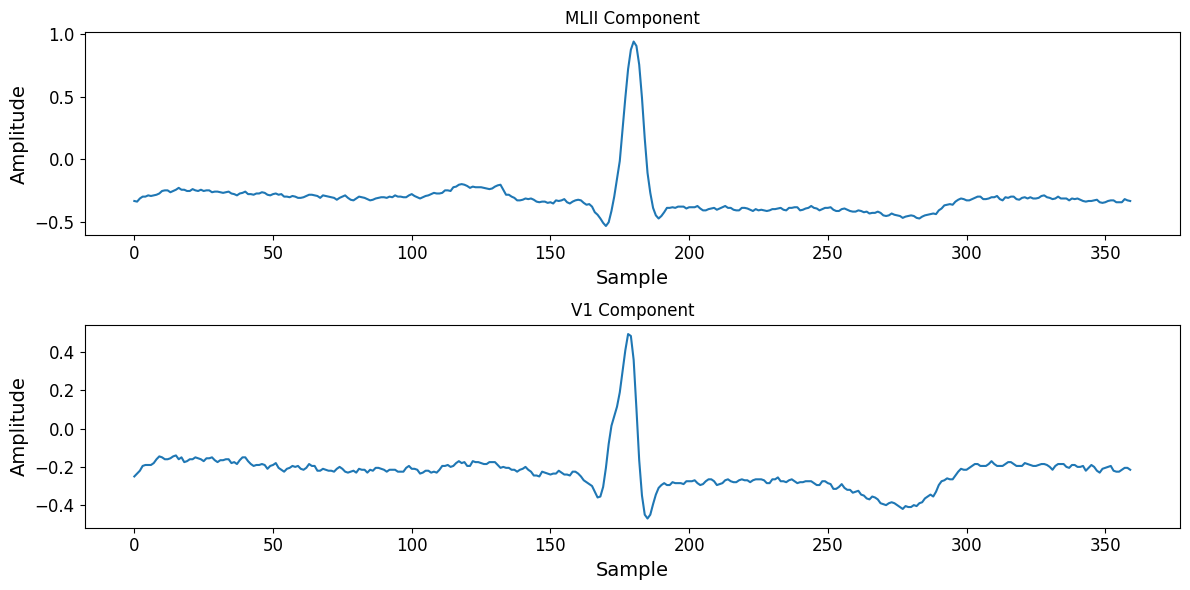

In [7]:
import matplotlib.pyplot as plt

# Extract the first signal from all_signals
first_signal = all_signals[0]

# Plot the first component (MLII)
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(first_signal[:, 0])
plt.title('MLII Component')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Plot the second component (V1)
plt.subplot(2, 1, 2)
plt.plot(first_signal[:, 1])
plt.title('V1 Component')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [8]:
all_swt_coeffs = []
all_reconstructed_signals = []

# signal process

In [9]:
all_swt_coeffs1 = []
all_swt_coeffs2 = []

all_reconstructed_signals1 = []
all_reconstructed_signals2 = []

In [ ]:
from tqdm import tqdm

def perform_iswt(coeffs, wavelet='db1'):
    # Perform Inverse SWT
    reconstructed_signal = pywt.iswt(coeffs, wavelet)
    return reconstructed_signal

# Main processing loop with tqdm
for signal in tqdm(all_signals, desc="Processing Signals"):
    # Perform SWT on the original signal
    swt_coeffs = perform_swt(signal[:,0], wavelet='db1')  # Specify the wavelet here
    all_swt_coeffs1.append(swt_coeffs)
    
    # Filter the SWT coefficients (you may need to adjust this part)
    filtered_coeffs = []
    for coeff in swt_coeffs:
        # Apply two-stage median filter and Savitzky-Golay filter to each coefficient
        filtered_detail = two_stage_median_filter(coeff[1])  # Detail coefficients
        smoothed_detail = apply_savitzky_golay(filtered_detail)
        filtered_coeffs.append((coeff[0], smoothed_detail))  # Append approximation and filtered detail

    # Perform ISWT to reconstruct the signal from the filtered coefficients
    reconstructed_signal = perform_iswt(filtered_coeffs, wavelet='db1')
    all_reconstructed_signals1.append(reconstructed_signal)



Processing Signals:  56%|█████▌    | 59650/107141 [01:58<01:35, 497.48it/s]

In [ ]:
for signal in tqdm(all_signals, desc="Processing Signals"):
    # Perform SWT on the original signal
    swt_coeffs = perform_swt(signal[:,1], wavelet='db1')  # Specify the wavelet here
    all_swt_coeffs2.append(swt_coeffs)
    
    # Filter the SWT coefficients (you may need to adjust this part)
    filtered_coeffs = []
    for coeff in swt_coeffs:
        # Apply two-stage median filter and Savitzky-Golay filter to each coefficient
        filtered_detail = two_stage_median_filter(coeff[1])  # Detail coefficients
        smoothed_detail = apply_savitzky_golay(filtered_detail)
        filtered_coeffs.append((coeff[0], smoothed_detail))  # Append approximation and filtered detail

    # Perform ISWT to reconstruct the signal from the filtered coefficients
    reconstructed_signal = perform_iswt(filtered_coeffs, wavelet='db1')
    all_reconstructed_signals2.append(reconstructed_signal)

# visualize the preprocess and original signal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list of reconstructed signals to a NumPy array

# Plot original signal
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(all_reconstructed_signals1[0], label='Reconstructed Signals MLII', color='blue')
plt.title('Reconstructed Signals MLII')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(all_reconstructed_signals2[0], label='Reconstructed Signals V1', color='red')
plt.title('Reconstructed Signals V1')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Convert lists of reconstructed signals to NumPy arrays
all_reconstructed_signals1 = np.array(all_reconstructed_signals1)
all_reconstructed_signals2 = np.array(all_reconstructed_signals2)


In [ ]:
len(all_reconstructed_signals2)

In [ ]:
# Ensure signals are of the same length
signal_length = all_reconstructed_signals1.shape[1]

# Stack signals into a single 2D array with two channels
all_signals_fin = np.stack((all_reconstructed_signals1, all_reconstructed_signals2), axis=-1)


In [ ]:
# Assuming signals are in shape (samples, length, channels)
# Reshape to fit (samples, height, width, channels)
all_signals_fin = all_signals_fin.reshape(
    (all_signals_fin.shape[0], signal_length, 1, 2)  # Adjust this based on your CNN's expected input
)


In [ ]:
from sklearn.model_selection import train_test_split

# Example split
X_train, X_test, y_train, y_test = train_test_split(all_signals_fin, all_labels, test_size=0.2, random_state=42)


In [ ]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Example labels

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform training labels
y_train = label_encoder.fit_transform(y_train)

# Transform test labels
y_test = label_encoder.transform(y_test)

# Convert to NumPy arrays
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print("y_train:", y_train)
print("y_test:", y_test)


In [ ]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [ ]:
X_train.shape

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Input
from tensorflow.keras.utils import to_categorical
import numpy as np

# Define dimensions
timesteps = 360  # Length of each signal
height = 1       # Number of channels (height)
width = 2        # Number of features per measurement (width)
channels = 1     # Number of channels

# Convert labels to one-hot encoded format
num_classes = 7  # Update this according to your number of classes
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Define the CNN model
cnn = Sequential([
    Input(shape=(height, width, channels)),
    Conv2D(32, (1, 2), activation='relu', padding='same'),  # Added padding to keep dimensions
    MaxPooling2D(pool_size=(1, 1)),  # Pooling with (1, 1) to avoid reducing dimensions
    Conv2D(64, (1, 2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(1, 1)),
    Flatten()
])

# Define the CNN-LSTM model
model = Sequential([
    TimeDistributed(cnn, input_shape=(timesteps, height, width, channels)),
    LSTM(units=50),  # Number of units can be adjusted
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test, y_test_one_hot))

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Print the first 20 actual and predicted values
print("Actual values (first 20):", y_test[:20])
print("Predicted values (first 20):", y_pred[:20])


In [ ]:
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train_one_hot, epochs=20, batch_size=32, validation_data=(X_test, y_test_one_hot))

# # Get predictions
# y_pred_probs = model.predict(X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# # Print the first 20 actual and predicted values
# print("Actual values (first 20):", y_test[:20])
# print("Predicted values (first 20):", y_pred[:20])

In [ ]:
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Precision: {results[2]}")


In [ ]:
import numpy as np

# Get predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Print the first 20 actual and predicted values
print("Actual values (first 20):", y_test[:20])
print("Predicted values (first 20):", y_pred[:20].flatten())


In [ ]:
# labels_fin=pd.Series(all_labels)

# labels_fin.value_counts()


In [ ]:
# len(all_signals_fin)
# labels_array=np.array(all_labels)

In [ ]:
# df_0=all_signals_fin[labels_fin=='/']
# df_1=all_signals_fin[labels_fin=='A']
# df_2=all_signals_fin[labels_fin=='E']
# df_3=all_signals_fin[labels_fin=='L']
# df_4=all_signals_fin[labels_fin=='N']
# df_5=all_signals_fin[labels_fin=='R']
# df_6=all_signals_fin[labels_fin=='V']
# y_df0=labels_array[labels_fin=='/']
# print(len(df_0))
# print(len(df_1))
# print(len(df_2))

# print(y_df0)
# len(y_df0)

In [ ]:
# from sklearn.utils import resample


In [ ]:
# df0_sampled=resample(df_0, replace=True, n_samples=20000, random_state=42)
# df1_sampled=resample(df_1, replace=True, n_samples=20000, random_state=42)
# df2_sampled=resample(df_2, replace=True, n_samples=20000, random_state=42)
# df3_sampled=resample(df_3, replace=True, n_samples=20000, random_state=42)
# df4_sampled=resample(df_4, replace=True, n_samples=20000, random_state=42)
# df5_sampled=resample(df_5, replace=True, n_samples=20000, random_state=42)
# df6_sampled=resample(df_6, replace=True, n_samples=20000, random_state=42)

In [ ]:
# y_0=['/']*len(df0_sampled)
# y_1=['A']*len(df1_sampled)
# y_2=['E']*len(df2_sampled)
# y_3=['L']*len(df3_sampled)
# y_4=['N']*len(df4_sampled)
# y_5=['R']*len(df5_sampled)
# y_6=['V']*len(df6_sampled)

In [ ]:
# X_final=[]
# X_final.extend(df0_sampled)
# X_final.extend(df1_sampled)
# X_final.extend(df2_sampled)
# X_final.extend(df3_sampled)
# X_final.extend(df4_sampled)
# X_final.extend(df5_sampled)
# X_final.extend(df6_sampled)

In [ ]:
# y_final=[]
# y_final.extend(y_0)
# y_final.extend(y_1)
# y_final.extend(y_2)
# y_final.extend(y_3)
# y_final.extend(y_4)
# y_final.extend(y_5)
# y_final.extend(y_6)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler()

In [ ]:
# scaled=scaler.fit_transform(X_final)


In [ ]:
# def check_strat(y):
#     dummy = pd.DataFrame(y,columns=["Labels"])
#     print("Value distribution:\n")
#     count = dummy["Labels"].value_counts()
#     percent = dummy["Labels"].value_counts(normalize=True).mul(100).round(2)
#     print(pd.concat([count,percent],axis=1,keys=["Counts","Percent"]))

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# strad=StratifiedShuffleSplit()
# assin_strad=strad.split(scaled, y_final)
# train_index, test_index=next(assin_strad)
# train_data_scaled=scaled[train_index]
# from sklearn.preprocessing import LabelEncoder
# lab=LabelEncoder()
# labels_final=lab.fit_transform(y_final)
# lab.classes_

In [ ]:
# train_label=labels_final[train_index]
# assin_val=strad.split(train_data_scaled, train_label)
# train_index_fin, val_index=next(assin_val)
# X_val=train_data_scaled[val_index]
# train_data_scaled_fin=train_data_scaled[train_index_fin]
# train_labels_fin=train_label[train_index_fin]
# y_val=train_label[val_index]
# test_data_scaled=scaled[test_index]
# test_labels=labels_final[test_index]

In [ ]:
# check_strat(test_labels)


In [ ]:
# check_strat(train_label)


In [ ]:
# import os

# # Define a path to the writable directory
# MODEL_PATH = os.path.join('/kaggle/working/', "saved_models")

# # Create the directory
# os.makedirs(MODEL_PATH, exist_ok=True)

# # Print the path to verify
# print(f"Directory created or exists at: {MODEL_PATH}")


# import pickle

# # a function to save trained models in pickle object
# def save_model(name,model,extension=".pickle"):
#     path = os.path.join(MODEL_PATH,name+extension)
#     print("Saving Model : ",name)
#     file = open(path,"wb")
#     pickle.dump(model,file)
#     file.close()

In [ ]:
# from tensorflow import keras
# CNN_X_train=train_data_scaled_fin.reshape(len(train_data_scaled_fin), len(train_data_scaled_fin[0]), 1)
# CNN_val=X_val.reshape(len(X_val), len(X_val[0]), 1)

In [ ]:
# import tensorflow as tf
# from tensorflow import keras

# # Define the CNN model
# CNN_model = keras.Sequential([
#     keras.layers.Conv1D(64, kernel_size=3, input_shape=(360, 1), activation="relu"),
#     keras.layers.MaxPooling1D(pool_size=2),
#     keras.layers.Conv1D(32, kernel_size=3, activation="relu"),
#     keras.layers.MaxPooling1D(pool_size=2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(7, activation="softmax")
# ])

# # Use `learning_rate` instead of `lr`
# opt = keras.optimizers.Adam(learning_rate=0.0001)

# # Compile the model
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# CNN_model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

# # Print the model summary
# CNN_model.summary()

# # Fit the model
# history = CNN_model.fit(CNN_X_train, train_labels_fin, epochs=10, batch_size=50, validation_data=(CNN_val, y_val))


In [ ]:
# cnn_prediction = CNN_model.predict(test_data_scaled)


In [ ]:
# predicted_classes = np.argmax(cnn_prediction, axis=1)

In [ ]:
# print(predicted_classes[0:20])
# print(test_labels[0:20])